# OpenAI Scholars: Sixth Steps - A PyTorch Tutorial

Over the course of the [OpenAI Scholars program](https://openai.com/blog/openai-scholars-spring-2020/), my mentor [Johannes](https://jotterbach.github.io/) has given me a number of very helpful pair programming tutorials to improve my facility with `PyTorch`.

Since they were useful to me, I see no reason not to share them with you. :-)

This is the very first tutorial, which we did a couple of months back. It's a common beginners' machine learning example: Training a logistic regression classifier to separate digits of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

If you're interested in a more verbose discussion about datasets and dataloaders in `PyTorch`, I recommend an [earlier blog post I wrote on this topic](https://katarinaslama.github.io/2020/04/02/OpenAI-blog3/).

### Import the requisite packages

Importing the packages you'll need is usually a good place to start.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tud
import torchvision.datasets as ds
import torchvision.transforms as tr
import torchvision.utils as tvu

import numpy as np
import pandas as pd

([`tqdm`](https://pypi.org/project/tqdm/) is a really cool package that I learned about during the program. It makes a handy progress bar for your network training. Also, the name of the package derives from the Arabic word root ["qadama", to precede](https://cooljugator.com/ar/%D9%82%D8%AF%D9%85), and here it means "progress". So "taqaddum" helps you track your network's progress.)

In [3]:
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

### Torvision datasets

The `torchvision.datasets` package (here, `ds`) has a method for downloading a nicely curated version of the MNIST dataset, which we can use for learning. We start by defining a root directory, where we will store the data. (It does not need to exist on your computer yet. `PyTorch` will create it for you if you don't have it.

In [4]:
root_directory = '~/pp_mnist'

We're going to apply some transforms to our data, including converting it to `PyTorch` tensors, and rescaling it to range from -1 to 1. We define the transforms here, but do not apply them yet.

In [5]:
transforms = tr.Compose([
    tr.ToTensor(),
    tr.Lambda(lambda x: (2. * x - 1).reshape(-1, ))
])

Next, we load the MNIST data the `torchvision.datasets` package. We do so separately for the training and test sets. We apply the transforms that we defined above. We set the `download` flag to `True` because we have not downloaded this data before. (If you already have the data in your root directory, you can save some time and compute by setting it to `False`).

In [6]:
train_ds = ds.MNIST(root=root_directory,
                    train=True,
                    transform=transforms,
                    download=True)

test_ds = ds.MNIST(root=root_directory,
                   train=False,
                   transform=transforms,
                   download=True)

### Torvision dataloaders

Now, we define dataloaders for our training and test sets, so that we can iterate through the MNIST examples in batches and in randomized order. Sometimes, the last batch is incomplete (if the training set size doesn't happen to be a multiple of your batch size), and this can cause problems if you don't consider that in subsequent code. An easy way to mitigate against this problem is by setting the `drop_last` flag to `True`. As you might have guessed, that excludes the last batch from your training and evaluation processes.

In [7]:
train_loader = tud.DataLoader(train_ds,
                              batch_size=128,
                              shuffle=True,
                              drop_last=True)

test_loader = tud.DataLoader(test_ds,
                             batch_size=128,
                             shuffle=False,
                             drop_last=True)

### Visualize some examples from your data

Now that we have the data, it's a good idea to take a look at (at least some of) it.
The first step is to extract some examples from the trainloader, and to do so, we turn it into an iterator.

In [8]:
train_iterator = iter(train_loader)

Then we call the `next` method on the train iterator, to get a batch of training examples. The zeroeth element has the data (the actual MNIST digits), and the first element has the labels.

In [9]:
this_batch, these_labels = train_iterator.next()

`torchvision` has a handy method called `make_grid`, which allows us to visualize examples on a grid.

In [10]:
tvu_fig = tvu.make_grid(this_batch[:16, ...].reshape(16, 1, 28, 28),
                        nrow=4,
                        normalize=True,
                        scale_each=True)

To actually plot the figure, we need to use the `matplotlib` library (`plt` below), and that library only really plays nice with numpy, so we convert our `PyTorch` tensor to `NumPy` in order to plot it. Images are formatted differently in `PyTorch` than `NumPy`, so we also change the order of the image dimensions, using the `permute` method.

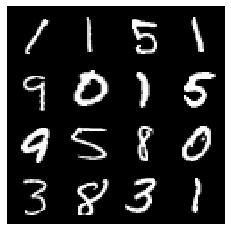

In [11]:
plt.imshow(tvu_fig.permute(1, 2, 0).data.numpy()) 
plt.axis('off')
pass

We can also take a look at the labels, corresponding to the data.

In [12]:
print(these_labels[:16])

tensor([1, 1, 5, 1, 9, 0, 1, 5, 9, 5, 8, 0, 3, 8, 3, 1])


See! We have the data. And the labels make sense. :-) Don't you wish all data collection was this easy?...

Onward!

### Define the model

Now that we have the data, and we have confirmed to ourselves that it looks as we would hope, we can define a model, which we will use to learn a mapping between the image data and the corresponding labels.

A good model to start with when you have discrete labels (in the case of the MNIST dataset, we have 10, one for each digit), is a logistic regression. But notice that the way we define a model in `PyTorch` (as below) is very general, and you can plug in all sorts of exciting models into this general code skeleton.

The defining features of a `PyTorch` module are the `__init__` and `forward` methods. In the `init` method, we define the model, i.e. the network architecture, by specifying any functions that we are planning to use.
In the `forward` method, we specify *how*, i.e. in what order, we want to apply those functions. 

In [13]:
class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.num_classes = 10
        self.logits = nn.Sequential(
            nn.Linear(28**2, # the shape of each image is 28*28 pixels
                      self.num_classes))

    def forward(self, x):
        return self.logits(x)

### Define the evaluation loop (test process)

Next, we define the evaluation loop. The evaluation loop will get called at the end of each training epoch (see the section, **Train the model**, below). Its purpose is to evaluate how well our model is doing on the test set. What happens in the evaluation loop does not affect the model weights.

In [14]:
def eval_loop(model, test_loader):
    # Set the model to evaluation mode. This saves a lot of computational work, because we don't need to compute
    # when we evaluate the model.
    model.eval()
    
    # Initialize a list to store accuracy values
    acc = []
    # Iterate through the test loader. Use tqdm to display our progress.
    for this_batch, these_labels in tqdm(test_loader, 
                                         leave=False):
        # Get model predictions for each batch.
        pred = model(this_batch)
        # Get labels out of the predictions, by simply extracting the maximal value from the real-valued predictions.
        pred_lbl = pred.argmax(dim=-1)
        # For each training example, store whether we predicted the correct label in our accuracy (acc) list
        acc += (pred_lbl == these_labels).numpy().tolist()
    # When we've gone through all the batches, return the mean of the accuracy counts.
    return np.mean(acc)

### Train the model

Finally, we are ready to train our model! To do so, we first create a model instance by calling our `LogReg` module from above.

In [15]:
model = LogReg()

Then, we create an optimizer, whom we will name `opt`. We choose the `Adam` optimizer, but `PyTorch` [has many optimizers that you can choose from](https://pytorch.org/docs/stable/optim.html). We select a [learning rate](https://en.wikipedia.org/wiki/Learning_rate), `lr`, of 0.001. Notice that the learning rate is itself a [hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) that you can optimize.

In [16]:
opt = torch.optim.Adam(model.parameters(), 
                       lr=1e-3)

We choose a criterion, `crit`, also known as a [loss function](https://en.wikipedia.org/wiki/Loss_function), which will help us determine how well the model is doing and in what direction to update its weights. We choose [`CrossEntropyLoss`](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html), which is usually a good choice for categorical data.

In [17]:
crit = nn.CrossEntropyLoss()

We will train for 10 [epochs](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/). In one epoch you loop through all of your training data once. You might try training with more epochs and see if that helps performance.

In [18]:
epochs = 10

Next, we loop through our epochs to train the model, while monitoring performance.

In [ ]:
for e in tqdm(range(epochs), 
              leave=True):
    # We set the model to "train" mode, which means that we will compute the gradient that we need, and update the weights.
    model.train()
    # We loop through all the batches in our train loader.
    for this_batch, these_labels in tqdm(train_loader, leave=False):
        # We want to set the gradient to 0 between each batch (weight update). Otherwise, PyTorch accumulates them, 
        # and bad things happen.    
        opt.zero_grad()
        # We compute model predictions by applying the model to a batch of data.
        pred = model(this_batch)
        # Once, we have the predictions, we calculate how bad they are by computing the loss (CrossEntropyLoss from above)
        # between the predictions and the true labels.
        loss = crit(pred, these_labels)
        # We use the "backward" command to compute the gradient that we need for updating the model.
        loss.backward()
        # We use the "step" command to actually update the model. 
        opt.step()
    
    # Now that we have an updated model, after having seen all the data once, we evaluate how well the model is doing
    # on the heldout test set, by calling our "eval_loop" from above.
    acc = eval_loop(model, test_loader)
    
    # And we print the results. If things are going well, the loss should be going down, and the accuracy should be going up.
    print('**epoch**: ', e)
    print('training loss: ', loss.detach().numpy())
    print('test accuracy: ', acc)

### You're done!

...and that's it for this first demo. I suggest that you try changing something in this notebook to see what happens. Can you make the accuracy go up more?